In [1]:
import random


from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [2]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

In [3]:
tokenizer_bert = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model_bert = AutoModelForTokenClassification.from_pretrained("allegro/herbert-base-cased")

tokenizer_gpt = AutoTokenizer.from_pretrained("sdadas/polish-gpt2-medium", add_prefix_space=True)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = AutoModelForTokenClassification.from_pretrained("sdadas/polish-gpt2-medium", pad_token_id=tokenizer_gpt.pad_token_id)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)

In [5]:
tokenizer_bert = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model_bert = AutoModelForTokenClassification.from_pretrained("allegro/herbert-base-cased")

tokenizer_gpt = AutoTokenizer.from_pretrained("sdadas/polish-gpt2-medium", add_prefix_space=True)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = AutoModelForTokenClassification.from_pretrained("sdadas/polish-gpt2-medium", pad_token_id=tokenizer_gpt.pad_token_id)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model_bert.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [7]:
model_gpt.eval()

GPT2ForTokenClassification(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): FastGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=1024, out_features=2

In [8]:
def get_bert_embeddings(text):
    # inputs = tokenizer_bert(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    inputs = tokenizer_bert(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model_bert(**inputs, output_hidden_states=True)
    all_hidden_states = outputs.hidden_states
    return all_hidden_states, inputs["input_ids"]

In [9]:
def get_gpt_embeddings(text):
    # inputs = tokenizer_gpt(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    inputs = tokenizer_gpt(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model_gpt(**inputs, output_hidden_states=True)
    all_hidden_states = outputs.hidden_states
    return all_hidden_states, inputs["input_ids"]

In [10]:
def get_unique_sentences(dataset, n):
    unique_samples = set()

    while len(unique_samples) < n:
        sample_index = random.randint(0, len(dataset["train"]) - 1)
        unique_samples.add(dataset["train"]["text"][sample_index])

    random_samples = list(unique_samples)
    return random_samples

In [11]:
def get_embeddings_similarity(token_indices, layer_emb):
    token_idx1, token_idx2 = random.sample(token_indices, 2)

    embedding1 = layer_emb[0, token_idx1, :].cpu().numpy().reshape(1, -1)
    embedding2 = layer_emb[0, token_idx2, :].cpu().numpy().reshape(1, -1)
    similarity = cosine_similarity(embedding1, embedding2)[0][0]
    return similarity

In [12]:
def get_cosine_similarities(dataset, n_sentences, sampled_words, model_embeddings=get_bert_embeddings, num_layers=12):
    unique_indices = random.sample(range(len(dataset["train"])), n_sentences)
    layer_similarity = {i: [] for i in range(num_layers+1)}

    for idx in unique_indices:
        text = dataset["train"]["text"][idx]
        try:
           embeddings, input_ids = model_embeddings(text)
        except:
            continue
    
        token_indices = list(range(1, input_ids.shape[1] - 1))

        for layer_idx, layer_emb in enumerate(embeddings):
            for _ in range(sampled_words):
                similarity = get_embeddings_similarity(token_indices, layer_emb)
                layer_similarity[layer_idx].append(similarity)

    return layer_similarity

In [13]:
cosine_similarities_bert = get_cosine_similarities(dataset, 100, 5)
mean_cosine_similarities_bert = [np.mean(cosine_similarities_bert[key]) for key in cosine_similarities_bert]

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


In [14]:
cosine_similarities_gpt = get_cosine_similarities(dataset, 100, 5, model_embeddings=get_gpt_embeddings, num_layers=24)
mean_cosine_similarities_gpt = [np.mean(cosine_similarities_gpt[key]) for key in cosine_similarities_gpt]

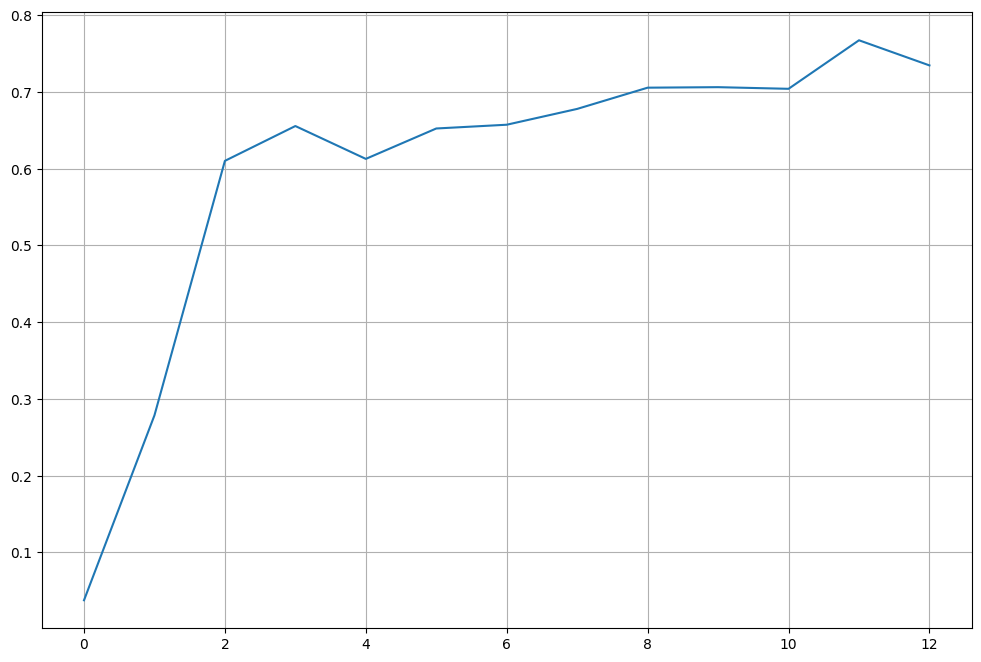

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(mean_cosine_similarities_bert)
plt.grid()
plt.show()

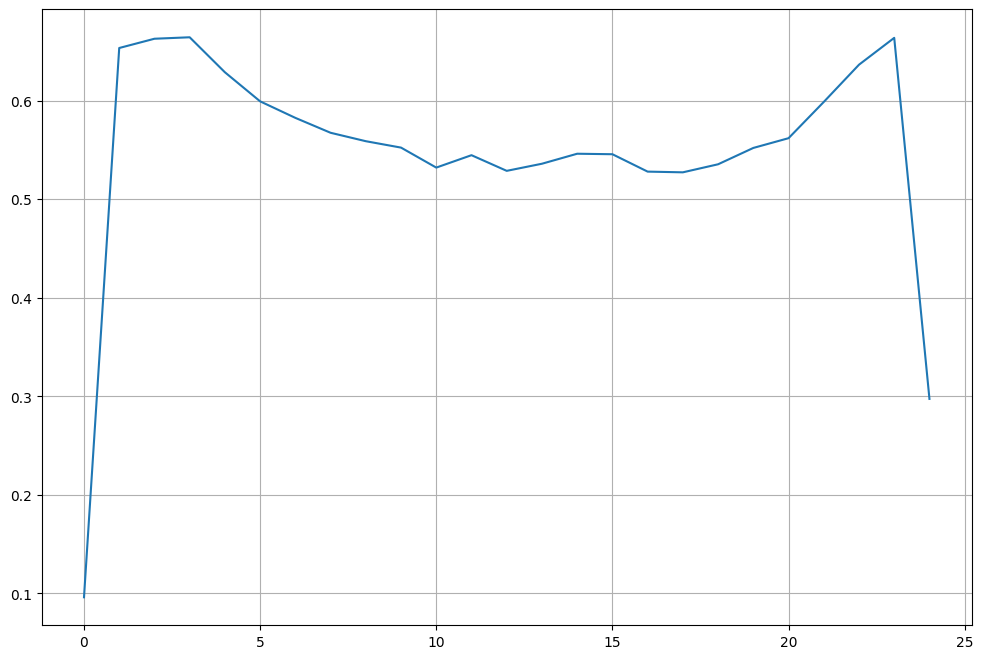

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(mean_cosine_similarities_gpt)
plt.grid()
plt.show()

In [17]:
from collections import Counter
import re

sentences = dataset["train"]["text"]
all_text = ' '.join(sentences).lower()
words = re.findall(r'\b\w+\b', all_text)
word_counts = Counter(words)
most_common_words = word_counts.most_common(10)
print(most_common_words)

[('w', 28311), ('i', 20480), ('się', 17198), ('na', 16060), ('z', 15307), ('nie', 11814), ('do', 11411), ('to', 8493), ('że', 8371), ('jest', 7017)]


In [18]:
def calculate_context_speficity(token_id, dataset, n_sentences, model_embeddings=get_bert_embeddings, num_layers=12, layer_num=-1):
    unique_indices = random.sample(range(len(dataset["train"])), n_sentences)
    # embeddings = {i: [] for i in range(num_layers+1)}
    embeddings = []

    for idx in range(100):
        text = dataset["train"]["text"][idx]
        try:
            all_hidden_states, input_ids = model_embeddings(text)
            hidden_states = all_hidden_states[layer_num]
        except:            
            continue

        if token_id in input_ids:
            token_index = (input_ids == token_id).nonzero(as_tuple=True)[1]
            embeddings.append(hidden_states.squeeze(0)[token_index].mean(0))

    cos_similarities = []
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            sim = cosine_similarity(embeddings[i].reshape(1, -1), embeddings[j].reshape(1, -1))
            cos_similarities.append(sim)

    return sum(cos_similarities) / len(cos_similarities) if cos_similarities else None

In [19]:
token_id = tokenizer_bert.convert_tokens_to_ids("nie")

similarities = []
for n in range(12):
    sim = calculate_context_speficity(token_id, dataset, 10, layer_num=n)
    similarities.append(sim)

In [20]:
similarities = [similarity.item() for similarity in similarities]

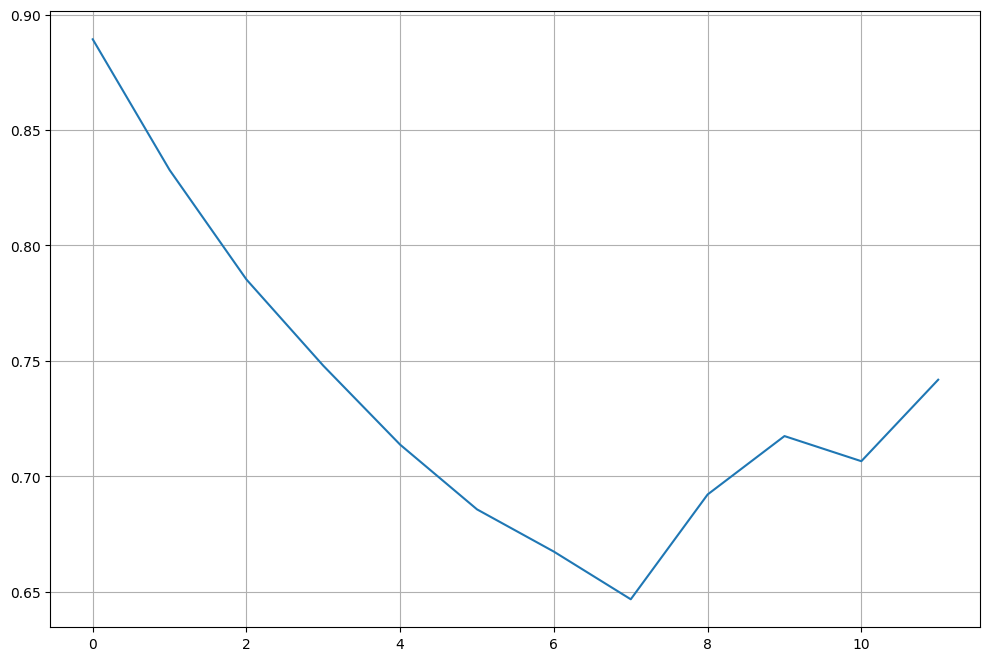

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(similarities)
plt.grid()
plt.show()

In [22]:
token_id = tokenizer_gpt.convert_tokens_to_ids("nie")

similarities_gpt = []

for n in range(24):
    sim = calculate_context_speficity(token_id, dataset, 10, layer_num=n, model_embeddings=get_gpt_embeddings)
    similarities_gpt.append(sim)

In [23]:
similarities_gpt = [similarity.item() for similarity in similarities_gpt]

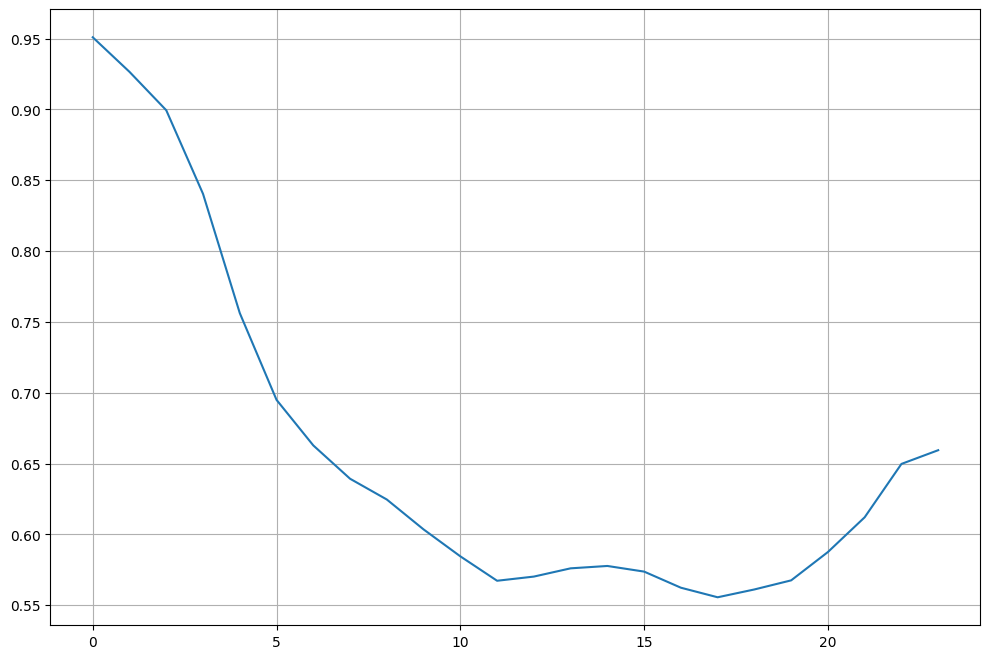

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(similarities_gpt)
plt.grid()
plt.show()